<a href="https://colab.research.google.com/github/Midonetwoo/Visikom-ML-/blob/main/TugasVisikom(ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Setup dan Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
# Import SVC from sklearn.svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import zipfile
import requests
from io import BytesIO

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 2. Download dan Extract Dataset
# Menggunakan simplified cats vs dogs dataset
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

--2025-06-12 10:15:28--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.215.201.253, 2600:1408:c400:1680::317f, 2600:1408:c400:168a::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.215.201.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   101MB/s    in 7.6s    

2025-06-12 10:15:36 (103 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [20]:
# 3. Fungsi untuk Load dan Preprocess Data
def load_images_from_folder(folder, label, max_images=5000):
    """Load images from folder with specified label"""
    images = []
    labels = []
    count = 0

    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and count < max_images:
            img_path = os.path.join(folder, filename)
            # Read image
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image to 128x128
                img_resized = cv2.resize(img, (128, 128))
                # Convert to grayscale for HOG
                img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
                images.append(img_gray)
                labels.append(label)
                count += 1

    return images, labels

# Load dataset
print("Loading dataset...")

cat_images, cat_labels = load_images_from_folder('/content/PetImages/Cat', 0, 5000)
dog_images, dog_labels = load_images_from_folder('/content/PetImages/Dog', 1, 5000)

# Combine data
all_images = cat_images + dog_images
# Corrected line: concatenate cat_labels and dog_labels
all_labels = cat_labels + dog_labels

print(f"Total images loaded: {len(all_images)}")
print(f"Cats: {len(cat_images)}, Dogs: {len(dog_images)}")


Loading dataset...
Total images loaded: 10000
Cats: 5000, Dogs: 5000


In [21]:
# 4. Feature Extraction menggunakan HOG (Histogram of Oriented Gradients)
def extract_hog_features(images):
    """Extract HOG features from images"""
    features = []

    for img in images:
        # Extract HOG features
        hog_features = hog(img,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=False)
        features.append(hog_features)

    return np.array(features)

print("Extracting HOG features...")
X = extract_hog_features(all_images)
y = np.array(all_labels)

print(f"Feature shape: {X.shape}")

Extracting HOG features...
Feature shape: (10000, 8100)


In [22]:
# 5. Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [23]:
# 6. Normalisasi features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# 7. Training Model SVC
print("Training SVM model...")
# Use SVC instead of SVC
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

Training SVM model...


SVC(random_state=42)

In [25]:
# 8. Prediksi dan Evaluasi
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

Accuracy: 0.7445

Classification Report:
              precision    recall  f1-score   support

         Cat       0.73      0.77      0.75      1000
         Dog       0.76      0.72      0.74      1000

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000


Confusion Matrix:
[[773 227]
 [284 716]]


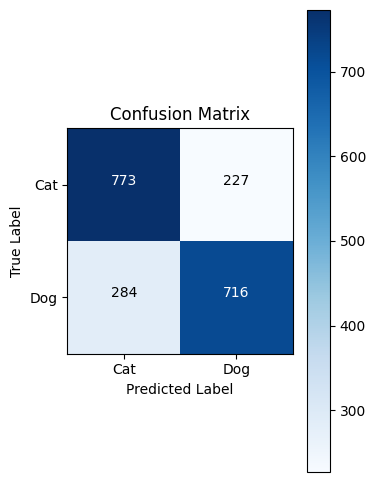

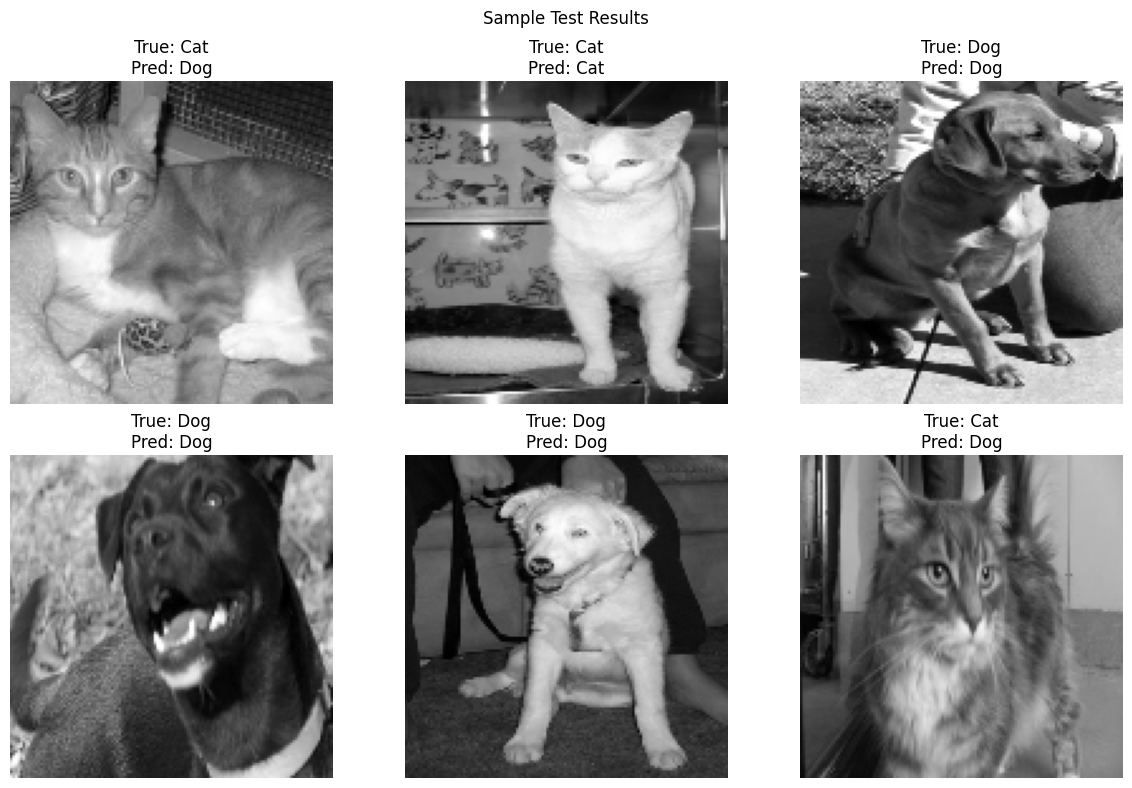

In [26]:
# 9. Visualisasi Hasil
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Cat', 'Dog'])
plt.yticks(tick_marks, ['Cat', 'Dog'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Show some test examples
# Select some test examples
test_indices_in_test_split = np.random.choice(len(X_test), 6, replace=False)

# Untuk menampilkan gambar, kita perlu menyimpan indeks asli saat membagi data
# Bagi juga indeks asli
indices = np.arange(len(all_images))
X_train_idx, X_test_idx, y_train_split, y_test_split = train_test_split(indices, y, test_size=0.2, random_state=42, stratify=y)

# Pastikan bahwa X_test_idx sekarang berisi indeks asli dari all_images yang sesuai dengan X_test

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample Test Results')

for idx, ax in enumerate(axes.flat):
    if idx < len(test_indices_in_test_split):
        # Dapatkan indeks dalam array X_test
        test_split_idx = test_indices_in_test_split[idx]
        # Dapatkan indeks asli dalam all_images menggunakan X_test_idx
        original_img_idx = X_test_idx[test_split_idx]

        # Dapatkan gambar asli menggunakan indeks asli
        original_img = all_images[original_img_idx]

        # Dapatkan label sebenarnya dan prediksi
        true_label = 'Cat' if y_test[test_split_idx] == 0 else 'Dog' # Gunakan y_test dari split fitur
        pred_label = 'Cat' if y_pred[test_split_idx] == 0 else 'Dog'

        # Tampilkan gambar asli
        ax.imshow(original_img, cmap=plt.cm.gray if len(original_img.shape) == 2 else None) # Tampilkan grayscale jika 1 channel
        ax.set_title(f'True: {true_label}\nPred: {pred_label}')
        ax.axis('off')

plt.tight_layout()
plt.show()



Feature Analysis:
HOG feature vector length: 8100
Training samples: 8000
Test samples: 2000


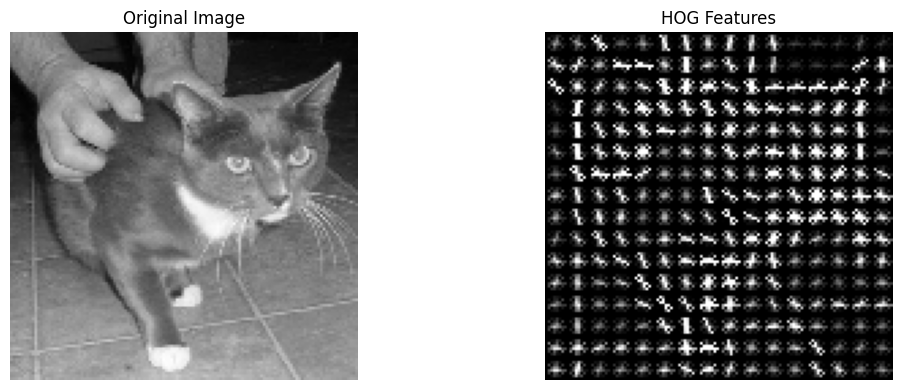

In [27]:
# 10. Feature Analysis
print(f"\nFeature Analysis:")
# Calculate HOG features for a sample image first to get its length
sample_img_for_length = all_images[0]
hog_features_sample, _ = hog(sample_img_for_length,
                             orientations=9,
                             pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2),
                             block_norm='L2-Hys',
                             visualize=True) # visualize is True, but we discard the image here

# Now print the length of the sample HOG feature vector
print(f"HOG feature vector length: {len(hog_features_sample)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Show HOG visualization for one sample (this part already defines hog_features and hog_image)
sample_img = all_images[0]
hog_features, hog_image = hog(sample_img,
                             orientations=9,
                             pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2),
                             block_norm='L2-Hys',
                             visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.axis('off')
ax1.imshow(sample_img, cmap=plt.cm.gray)
ax1.set_title('Original Image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG Features')

plt.tight_layout()
plt.show()

In [29]:
print("TUGAS")
print("Dataset: Cats vs Dogs (Microsoft)")
print("Preprocessing: Resize ke 128x128, Convert ke grayscale")
print("Feature Extraction: HOG (Histogram of Oriented Gradients)")
print("Algoritma ML: Support Vector Classifier (SVC)")
print(f"Akurasi: {accuracy:.4f}")
print("Link Dataset: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

TUGAS
Dataset: Cats vs Dogs (Microsoft)
Preprocessing: Resize ke 128x128, Convert ke grayscale
Feature Extraction: HOG (Histogram of Oriented Gradients)
Algoritma ML: Support Vector Classifier (SVC)
Akurasi: 0.7445
Link Dataset: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
